!pip install seaborn# Demand Forecasting

In [8]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.stats import describe

import seaborn as sns
from pylab import rcParams

pd.options.display.max_columns = 12
pd.options.display.max_rows = 24

# disable warnings in Anaconda
warnings.simplefilter('ignore')

# plots inisde jupyter notebook
%matplotlib inline

sns.set(style='darkgrid', palette='muted')
color_scheme = {
    'red': '#F1637A',
    'green': '#6ABB3E',
    'blue': '#3D8DEA',
    'black': '#000000'
}

# use svg for all plots within inline backend
%config InlineBackend.figure_format = 'svg'

# increase default plot size
rcParams['figure.figsize'] = 8, 6

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Before we do anything, we want to have both sets in a format with 500 sales columns and 1 row for each day.

In [3]:
df_train.index = pd.to_datetime(df_train['date'])
df_train.drop('date', axis=1, inplace=True)
df_test.index = pd.to_datetime(df_test['date'])
df_test.drop('date', axis=1, inplace=True)

In [4]:
df_train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [5]:
from itertools import product, starmap


def storeitems():
    return product(range(1,51), range(1,11))


def storeitems_column_names():
    return list(starmap(lambda i,s: f'item_{i}_store_{s}_sales', storeitems()))


def sales_by_storeitem(df):
    ret = pd.DataFrame(index=df.index.unique())
    for i, s in storeitems():
        ret[f'item_{i}_store_{s}_sales'] = df[(df['item'] == i) & (df['store'] == s)]['sales'].values
    return ret

In [6]:
df_train = sales_by_storeitem(df_train)
# for test set, we just fill y values with zeros (they won't be used anyway)
df_test['sales'] = np.zeros(df_test.shape[0])
df_test = sales_by_storeitem(df_test)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Columns: 500 entries, item_1_store_1_sales to item_50_store_10_sales
dtypes: int64(500)
memory usage: 7.0 MB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2018-01-01 to 2018-03-31
Columns: 500 entries, item_1_store_1_sales to item_50_store_10_sales
dtypes: float64(500)
memory usage: 352.3 KB


We combine data to prepare it for the model, and later split back into train and test set, not to repeat same transformations twice.

In [9]:
# make sure all column names are the same and in the same order
col_names = list(zip(df_test.columns, df_train.columns))
for cn in col_names:
    assert cn[0] == cn[1]

In [10]:
df_test['is_test'] = np.repeat(True, df_test.shape[0])
df_train['is_test'] = np.repeat(False, df_train.shape[0])
df_total = pd.concat([df_train, df_test])
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1916 entries, 2013-01-01 to 2018-03-31
Columns: 501 entries, item_1_store_1_sales to is_test
dtypes: bool(1), float64(500)
memory usage: 7.3 MB


In [11]:
weekday_df = pd.get_dummies(df_total.index.weekday, prefix='weekday')
weekday_df.index = df_total.index

In [12]:
month_df = pd.get_dummies(df_total.index.month, prefix='month')
month_df.index =  df_total.index

In [13]:
df_total = pd.concat([weekday_df, month_df, df_total], axis=1)

In [14]:
assert df_total.isnull().any().any() == False

We also want to append sales from previous day to each row, which we will then use as input data.

In [15]:
def shift_series(series, days):
    return series.transform(lambda x: x.shift(days))


def shift_series_in_df(df, series_names=[], days_delta=90):
    ret = pd.DataFrame(index=df.index.copy())
    str_sgn = 'future' if np.sign(days_delta) < 0 else 'past'
    for sn in series_names:
        ret[f'{sn}_{str_sgn}_{np.abs(days_delta)}'] = shift_series(df[sn], days_delta)
    return ret

    
def stack_shifted_sales(df, days_deltas=[1, 90, 360]):
    names = storeitems_column_names()
    dfs = [df.copy()]
    for delta in days_deltas:
        shifted = shift_series_in_df(df, series_names=names, days_delta=delta)
        dfs.append(shifted)
    return pd.concat(dfs, axis=1, copy=False)

In [16]:
df_total = stack_shifted_sales(df_total, days_deltas=[1])
df_total.dropna(inplace=True)

In [17]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1915 entries, 2013-01-02 to 2018-03-31
Columns: 1020 entries, weekday_0 to item_50_store_10_sales_past_1
dtypes: bool(1), float64(1000), uint8(19)
memory usage: 14.7 MB


We need to make sure that stacked and not-stacked sales columns appar in the same order. We do this by sorting the names (as strings), which works fine because we only need 1 past day for the network (see regression models and their rolling mechanism if you are interested in rolling more than 1 past days of sales as input).

In [18]:
sales_cols = [col for col in df_total.columns if '_sales' in col and '_sales_' not in col]
stacked_sales_cols = [col for col in df_total.columns if '_sales_' in col]
other_cols = [col for col in df_total.columns if col not in set(sales_cols) and col not in set(stacked_sales_cols)]

sales_cols = sorted(sales_cols)
stacked_sales_cols = sorted(stacked_sales_cols)

new_cols = other_cols + stacked_sales_cols + sales_cols

In [19]:
df_total = df_total.reindex(columns=new_cols)

In [20]:
assert df_total.isnull().any().any() == False

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [22]:
scaler = MinMaxScaler(feature_range=(0,1))
cols_to_scale = [col for col in df_total.columns if 'weekday' not in col and 'month' not in col]
scaled_cols = scaler.fit_transform(df_total[cols_to_scale])
df_total[cols_to_scale] = scaled_cols

In [23]:
df_train = df_total[df_total['is_test'] == False].drop('is_test', axis=1)
df_test = df_total[df_total['is_test'] == True].drop('is_test', axis=1)

In [24]:
X_cols_stacked = [col for col in df_train.columns if '_past_' in col]
X_cols_caldata = [col for col in df_train.columns if 'weekday_' in col or 'month_' in col or 'year' in col]
X_cols = X_cols_stacked + X_cols_caldata

X = df_train[X_cols]

In [25]:
X_colset = set(X_cols)
y_cols = [col for col in df_train.columns if col not in X_colset]

y = df_train[y_cols]

In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Columns: 519 entries, item_10_store_10_sales_past_1 to month_12
dtypes: float64(500), uint8(19)
memory usage: 7.0 MB


In [27]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Columns: 500 entries, item_10_store_10_sales to item_9_store_9_sales
dtypes: float64(500)
memory usage: 7.0 MB


In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

In [29]:
X_valid, y_valid = X_valid.head(90), y_valid.head(90)

For Keras, we need to make further transformations on input values:

In [30]:
X_train_vals = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_vals = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

In [31]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Conv1D, Input, Dropout, AvgPool1D, Reshape, Concatenate

2023-02-21 19:35:43.626497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Simple LSTM model:

In [32]:
basic_model = Sequential()
basic_model.add(LSTM(500, input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])))
basic_model.add(Dense(500))
basic_model.compile(loss='mean_absolute_error', optimizer='adam')

2023-02-21 19:36:05.785328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 19:36:05.815233: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 


More complex model combining LSTM with convolutional layers:

In [33]:
inputs = Input(shape=(X_train_vals.shape[1], X_train_vals.shape[2]))
# top pipeline
top_lstm = LSTM(500)(inputs)
top_dense = Dense(500, activation='relu')(top_lstm)
top_dropout = Dropout(0.5)(top_dense)
# bottom pipeline
bottom_dense = Dense(500)(inputs)
bottom_conv1 = Conv1D(
    500, 
    kernel_size=1,
    input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])
)(bottom_dense)
bottom_conv2 = Conv1D(
    1000,
    kernel_size=50,
    padding='same',
    activation='relu'
)(bottom_conv1)
bottom_conv3 = Conv1D(
    500,
    kernel_size=10,
    padding='same',
    activation='relu'
)(bottom_conv2)
bottom_pooling = AvgPool1D(
    pool_size=60, 
    padding='same'
)(bottom_conv3)
bottom_reshape = Reshape(
    target_shape=[500]
)(bottom_conv3)
# concat output from both pipelines
final_concat = Concatenate()([top_dropout, bottom_reshape])
final_dense = Dense(500)(final_concat)
# compile and return
complex_model = Model(inputs=inputs, outputs=final_dense)
complex_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])

Now we can fit the models:

In [34]:
basic_history = basic_model.fit(
    X_train_vals, 
    y_train.values, 
    epochs=40, 
    batch_size=30,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False
)

Epoch 1/40
49/49 - 4s - loss: 0.1417 - val_loss: 0.1084 - 4s/epoch - 73ms/step
Epoch 2/40
49/49 - 1s - loss: 0.0941 - val_loss: 0.0843 - 1s/epoch - 26ms/step
Epoch 3/40
49/49 - 1s - loss: 0.0830 - val_loss: 0.0688 - 742ms/epoch - 15ms/step
Epoch 4/40
49/49 - 1s - loss: 0.0748 - val_loss: 0.0626 - 802ms/epoch - 16ms/step
Epoch 5/40
49/49 - 1s - loss: 0.0701 - val_loss: 0.0587 - 981ms/epoch - 20ms/step
Epoch 6/40
49/49 - 1s - loss: 0.0658 - val_loss: 0.0637 - 866ms/epoch - 18ms/step
Epoch 7/40
49/49 - 1s - loss: 0.0659 - val_loss: 0.0660 - 565ms/epoch - 12ms/step
Epoch 8/40
49/49 - 1s - loss: 0.0717 - val_loss: 0.0723 - 1s/epoch - 24ms/step
Epoch 9/40
49/49 - 1s - loss: 0.1063 - val_loss: 0.0823 - 899ms/epoch - 18ms/step
Epoch 10/40
49/49 - 1s - loss: 0.0812 - val_loss: 0.0765 - 762ms/epoch - 16ms/step
Epoch 11/40
49/49 - 1s - loss: 0.0887 - val_loss: 0.0688 - 959ms/epoch - 20ms/step
Epoch 12/40
49/49 - 1s - loss: 0.0775 - val_loss: 0.0728 - 580ms/epoch - 12ms/step
Epoch 13/40
49/49 - 1s

In [35]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

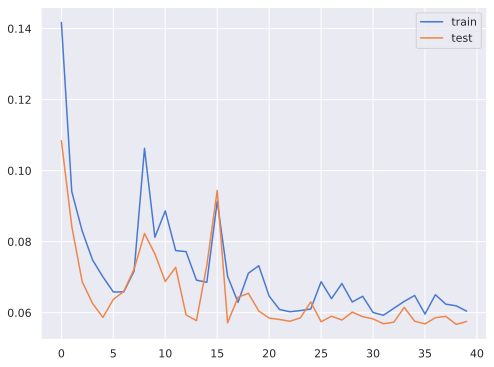

In [36]:
plot_history(basic_history)

In [37]:
complex_history = complex_model.fit(
    X_train_vals, 
    y_train.values, 
    epochs=20, 
    batch_size=70,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False
)

Epoch 1/20
21/21 - 16s - loss: 0.0419 - mape: 508.2155 - val_loss: 0.0171 - val_mape: 23.9664 - 16s/epoch - 761ms/step
Epoch 2/20
21/21 - 13s - loss: 0.0174 - mape: 443.4625 - val_loss: 0.0091 - val_mape: 20.8599 - 13s/epoch - 628ms/step
Epoch 3/20
21/21 - 13s - loss: 0.0095 - mape: 393.0891 - val_loss: 0.0093 - val_mape: 17.2494 - 13s/epoch - 629ms/step
Epoch 4/20
21/21 - 14s - loss: 0.0122 - mape: 455.3522 - val_loss: 0.0107 - val_mape: 23.2159 - 14s/epoch - 646ms/step
Epoch 5/20
21/21 - 13s - loss: 0.0110 - mape: 309.0329 - val_loss: 0.0072 - val_mape: 18.4812 - 13s/epoch - 637ms/step
Epoch 6/20
21/21 - 13s - loss: 0.0094 - mape: 411.4231 - val_loss: 0.0064 - val_mape: 14.6720 - 13s/epoch - 631ms/step
Epoch 7/20
21/21 - 14s - loss: 0.0065 - mape: 437.0069 - val_loss: 0.0056 - val_mape: 14.3986 - 14s/epoch - 663ms/step
Epoch 8/20
21/21 - 13s - loss: 0.0096 - mape: 380.7839 - val_loss: 0.0055 - val_mape: 15.1613 - 13s/epoch - 609ms/step
Epoch 9/20
21/21 - 14s - loss: 0.0120 - mape: 27

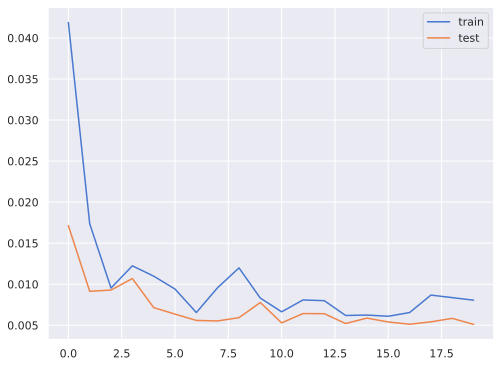

In [38]:
plot_history(complex_history)

## Evaluating model predictions

In [39]:
def model_eval(model, X_test, y_test):
    """
    Evaluate (step-by-step) model predictions from X_test and return predictions and real values in comparable format.
    """
    # prepare data
    sales_x_cols = [col for col in X_test.columns if 'sales' in col]
    sales_x_idxs = [X_test.columns.get_loc(col) for col in sales_x_cols]
    sales_y_cols = [col for col in y_test.columns if 'sales' in col]
    sales_y_idxs = [y_test.columns.get_loc(col) for col in sales_y_cols]
    n_samples = y_test.shape[0]
    y_pred = np.zeros(y_test.shape)
    # iterate
    x_next = X_test.iloc[0].values
    for i in range(0, n_samples):
        x_arr = np.array([x_next])
        x_arr = x_arr.reshape(x_arr.shape[0], 1, x_arr.shape[1])
        y_pred[i] = model.predict(x_arr)[0] # input for prediction must be 2d, output is immediately extracted from 2d to 1d
        try:
            x_next = X_test.iloc[i+1].values
            x_next[sales_x_idxs] = y_pred[i][sales_y_idxs]
        except IndexError:
            pass  # this happens on last iteration, and x_next does not matter anymore
    return y_pred, y_test.values


def unscale(y_arr, scaler, template_df, toint=False):
    """
    Unscale array y_arr of model predictions, based on a scaler fitted 
    to template_df.
    """
    tmp = template_df.copy()
    tmp[y_cols] = pd.DataFrame(y_arr, index=tmp.index)
    tmp[cols_to_scale] = scaler.inverse_transform(tmp[cols_to_scale])
    if toint:
        return tmp[y_cols].astype(int)
    return tmp[y_cols]


def vector_smape(y_pred, y_real):
    nom = np.abs(y_pred-y_real)
    denom = (np.abs(y_pred) + np.abs(y_real)) / 2
    results = nom / denom
    return 100*np.mean(results)  # in percent, same as at kaggle

In [40]:
y_pred_basic, y_real = model_eval(basic_model, X_valid, y_valid)

1/1 [==============================] - 0s 58ms/step


In [41]:
y_pred_complex = model_eval(complex_model, X_valid, y_valid)[0]

1/1 [==============================] - 0s 97ms/step


In [42]:
# this is just for unscaling
template_df = pd.concat([X_valid, y_valid], axis=1)
template_df['is_test'] = np.repeat(True, template_df.shape[0])

In [43]:
basic_pred = unscale(y_pred_basic, scaler, template_df, toint=True)
complex_pred = unscale(y_pred_complex, scaler, template_df, toint=True)
real = unscale(y_real, scaler, template_df, toint=True)

In [44]:
basic_smapes = [vector_smape(basic_pred[col], real[col]) for col in basic_pred.columns]
complex_smapes = [vector_smape(complex_pred[col], real[col]) for col in complex_pred.columns]

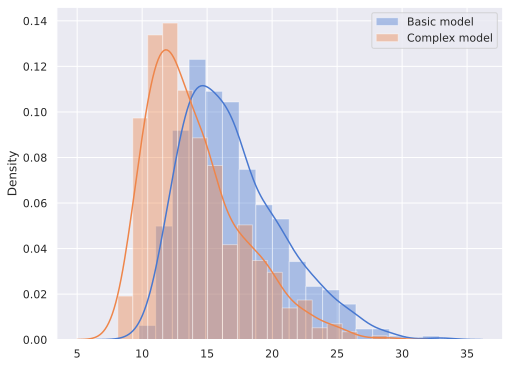

In [45]:
sns.distplot(basic_smapes, label='Basic model')
sns.distplot(complex_smapes, label='Complex model')
plt.legend(loc='upper right')
plt.savefig('smape_basic_vs_complex.svg')
plt.show()

Depending on training parameters, basic model can sometimes achieve results comparable to the complex one, however after uploading to Kaggle complex model achieved better (and more consistent) results.

In [46]:
describe(basic_smapes)

DescribeResult(nobs=500, minmax=(9.75791803646745, 32.8683937729631), mean=16.975355252864517, variance=14.706397902640127, skewness=0.8578320528551435, kurtosis=0.49284224222200557)

In [47]:
describe(complex_smapes)

DescribeResult(nobs=500, minmax=(8.126623929859342, 28.841965361727684), mean=14.05270825949733, variance=13.125985843000414, skewness=0.9890268577852144, kurtosis=0.7268880122756332)

### Visualizing model prediction
We will plot predictions for a sample store and item.

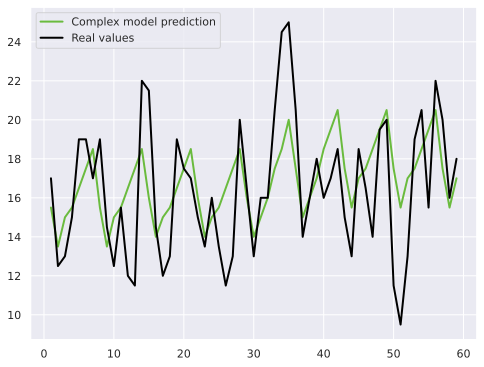

In [48]:
store, item = 1,1
plot_lengths = [60]
rolling_mean_windows = [2]  # to make plots more readable
storeitem_col = f'item_{item}_store_{store}_sales'

for pl, mw in zip(plot_lengths, rolling_mean_windows):
    plt.plot(complex_pred[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['green'],
             lw=2, 
             label='Complex model prediction')
    plt.plot(real[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['black'],
             lw=2, 
             label='Real values')
    plt.legend(loc='upper left')
    plt.savefig(f'plot_prediction_{pl}_{mw}.svg')
    plt.show()

In [49]:
filename = 'neuralNetwork.sav'
filename1 = 'basicmodel.sav'

In [50]:
import pickle

In [51]:
pickle.dump(complex_model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://62c42501-5800-40e7-b25d-e4611f9095b4/assets


INFO:tensorflow:Assets written to: ram://62c42501-5800-40e7-b25d-e4611f9095b4/assets


In [52]:
pickle.dump(basic_model, open(filename1, 'wb'))

INFO:tensorflow:Assets written to: ram://211604f9-bdd0-42de-8cf6-941f62333d82/assets


INFO:tensorflow:Assets written to: ram://211604f9-bdd0-42de-8cf6-941f62333d82/assets


In [53]:
pd.DataFrame(complex_pred).to_csv("file.csv")

In [54]:
pd.DataFrame(real).to_csv("file1.csv")